# Telecom Churn Prediction



# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [15]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from IPython.display import Markdown, display ,HTML
#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.animation as animation

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [16]:
#COMMENT THIS SECTION INCASE RUNNING THIS NOTEBOOK LOCALLY

#Checking the kaggle paths for the uploaded datasets
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [17]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

#data = pd.read_csv("/kaggle/input/kagglelabstest2021/train.csv")
#unseen = pd.read_csv("/kaggle/input/kagglelabstest2021/test.csv")
#sample = pd.read_csv("/kaggle/input/kagglelabstest2021/sample.csv")
#data_dict = pd.read_csv("/kaggle/input/kagglelabstest2021/data_dictionary.csv")

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [18]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [19]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [20]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

### 2. Handling Missing Data

In [21]:
# Utility method
def get_null_percentage(dataframe) :
    df = dataframe.isnull().sum() * 100 / len(dataframe)
    df = pd.DataFrame({'Column Name': df.index, 'Null Percentage': df.values})
    df = df.sort_values(by='Null Percentage', ascending=False)
    return df

In [22]:
percent_missing_df = get_null_percentage(data)
percent_missing_df.reset_index(drop=True, inplace=True)
pd.set_option('display.max_rows', None)
percent_missing_df

#Observations:

# Here recharge columns being null could be considered as 0 recharge value.
# Let's imput for some of the columns related recharge


,Column Name,Null Percentage
0,arpu_3g_6,74.902499
1,count_rech_2g_6,74.902499
2,night_pck_user_6,74.902499
3,arpu_2g_6,74.902499
4,date_of_last_rech_data_6,74.902499
5,total_rech_data_6,74.902499
6,av_rech_amt_data_6,74.902499
7,max_rech_data_6,74.902499
8,count_rech_3g_6,74.902499
9,fb_user_6,74.902499


In [23]:
# For some of recharge columns NAN can be considered as 0 recharge value.

# let's create new dataframe before changes.

tele_df = data

#Inputing NA values by 0
tele_df['total_rech_data_6'] = tele_df['total_rech_data_6'].replace(np.NaN,0.0)
tele_df['total_rech_data_7'] = tele_df['total_rech_data_7'].replace(np.NaN,0.0)
tele_df['total_rech_data_8'] = tele_df['total_rech_data_8'].replace(np.NaN,0.0)

tele_df['av_rech_amt_data_6'] = tele_df['av_rech_amt_data_6'].replace(np.NaN,0.0)
tele_df['av_rech_amt_data_7'] = tele_df['av_rech_amt_data_7'].replace(np.NaN,0.0)
tele_df['av_rech_amt_data_8'] = tele_df['av_rech_amt_data_8'].replace(np.NaN,0.0)

In [24]:
percent_missing_df = get_null_percentage(tele_df)
percent_missing_df.reset_index(drop=True, inplace=True)
pd.set_option('display.max_rows', None)
percent_missing_df

,Column Name,Null Percentage
0,arpu_2g_6,74.902499
1,count_rech_3g_6,74.902499
2,fb_user_6,74.902499
3,max_rech_data_6,74.902499
4,date_of_last_rech_data_6,74.902499
5,count_rech_2g_6,74.902499
6,night_pck_user_6,74.902499
7,arpu_3g_6,74.902499
8,count_rech_3g_7,74.478207
9,count_rech_2g_7,74.478207


In [25]:
#As there are so much data is still missing let's remove columns having more than 10% missing data.

missing_data_percent = 100*tele_df.isnull().sum()/len(tele_df)


In [26]:
new_vars = missing_data_percent[missing_data_percent.le(10)].index
new_vars

Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7',
       'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'churn_probability'],
      dtype='object', length=148)

In [27]:
# Let's have dataframe with fitered columns

tele_df_filtered = tele_df[new_vars]
tele_df_filtered.shape 

(69999, 148)

In [28]:
# Dropping rest null values which is small in number.

tele_df_filtered = tele_df_filtered.dropna()
tele_df_filtered.shape

(61895, 148)

# 3. Exploratory Data Analysis

In [29]:
# Utility Methods

def header(string):
    display(Markdown("------ "))
    display(Markdown("### "+string))

def log(string):
    display(Markdown("> <span style='color:blue'>"+string+"</span>"))

    
def get_variable_type(element) :
    
    # Check is columns are of Contineous or Categorical variable.
    # Assumption is that if 
    #             unique count < 20 then categorical 
    #             unique count >= 20 and dtype = [int64 or float64] then contineous
     
    if element==0:
        return "Not Known"
    elif element < 20 and element!=0 :
        return "Categorical"
    elif element >= 20 and element!=0 :
        return "Contineous"     

def get_meta_data(dataframe) :
    
     #Method to get Meta-Data about any dataframe passed 
    
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes.astype(str), 
                    'Non_Null_Count': dataframe.count(axis = 0).astype(int), 
                    'Null_Count': dataframe.isnull().sum().astype(int), 
                    'Null_Percentage': dataframe.isnull().sum()/len(dataframe) * 100, 
                    'Unique_Values_Count': dataframe.nunique().astype(int) 
                     })
    
    metadata_matrix = predict_variable_type(metadata_matrix)
    return metadata_matrix

def list_potential_categorical_type(dataframe,main) :
    header("Stats for potential Categorical datatype columns")
    metadata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
   
    length = len(metadata_matrix_categorical)
    if length == 0 :
        header_red("No Categorical columns in given dataset.")  
    else :    
        metadata_matrix_categorical = metadata_matrix_categorical.filter(["Datatype","Unique_Values_Count"])
        metadata_matrix_categorical.sort_values(["Unique_Values_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check :
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({"index":name_list,"Unique_Values":values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical,temp,how='inner',on='index')
        display(metadata_matrix_categorical.set_index("index"))
        
def predict_variable_type(metadata_matrix):
    metadata_matrix["Variable_Type"] = metadata_matrix["Unique_Values_Count"].apply(get_variable_type).astype(str)
    metadata_matrix["frequency"] = metadata_matrix["Null_Count"] - metadata_matrix["Null_Count"]
    metadata_matrix["frequency"].astype(int)
    return metadata_matrix 

In [30]:
list_potential_categorical_type(get_meta_data(tele_df_filtered),tele_df_filtered)

------ 

### Stats for potential Categorical datatype columns

,Datatype,Unique_Values_Count,Unique_Values
index,,,
monthly_3g_7,int64,13,"[0, 1, 2, 3, 5, 4, 8, 6, 7, 16, 14, 9, 10]"
monthly_3g_8,int64,12,"[0, 1, 2, 3, 4, 8, 5, 6, 9, 7, 16, 10]"
monthly_3g_6,int64,10,"[0, 1, 2, 4, 3, 6, 8, 5, 7, 9]"
monthly_2g_8,int64,6,"[0, 1, 2, 4, 3, 5]"
monthly_2g_7,int64,6,"[0, 1, 2, 4, 3, 5]"
monthly_2g_6,int64,5,"[0, 1, 2, 3, 4]"
churn_probability,int64,2,"[0, 1]"
loc_og_t2o_mou,float64,1,[0.0]
std_ic_t2o_mou_8,float64,1,[0.0]


In [31]:
# Observations from above stats

# ** We can drop the columns with single unique value, as it will not add any value to our analysis.


In [32]:
drop_col_with_unique_col =['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 
                          'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 
                          'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 
                          'std_og_t2c_mou_8',  'std_ic_t2o_mou_6', 
                          'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']

In [33]:
log("Features before dropping unique values : "+ str(tele_df_filtered.shape[1]))
tele_df_filtered.drop(drop_col_with_unique_col,axis=1,inplace=True)
log("Features after dropping unique values : "+ str(tele_df_filtered.shape[1]))

> <span style='color:blue'>Features before dropping unique values : 148</span>

> <span style='color:blue'>Features after dropping unique values : 135</span>

In [34]:
# Rest of date columns like date_of_last_rech_* are also not adding any values
# Let's drop those also

tele_df_filtered.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], axis=1,inplace=True)


In [35]:
tele_df_filtered.shape

(61895, 132)

#### Explore the data fields

In [36]:
meta_df = get_meta_data(tele_df_filtered)

In [37]:
meta_df_count = meta_df[meta_df["Datatype"] == 'object']
date_col = meta_df_count.index.tolist()
date_col

[]

In [38]:
list_potential_categorical_type(get_meta_data(tele_df_filtered),tele_df_filtered)

------ 

### Stats for potential Categorical datatype columns

,Datatype,Unique_Values_Count,Unique_Values
index,,,
monthly_3g_7,int64,13,"[0, 1, 2, 3, 5, 4, 8, 6, 7, 16, 14, 9, 10]"
monthly_3g_8,int64,12,"[0, 1, 2, 3, 4, 8, 5, 6, 9, 7, 16, 10]"
monthly_3g_6,int64,10,"[0, 1, 2, 4, 3, 6, 8, 5, 7, 9]"
monthly_2g_7,int64,6,"[0, 1, 2, 4, 3, 5]"
monthly_2g_8,int64,6,"[0, 1, 2, 4, 3, 5]"
monthly_2g_6,int64,5,"[0, 1, 2, 3, 4]"
churn_probability,int64,2,"[0, 1]"


#### Analyse recharge amount attributes

In [39]:
# Recharge amount related variables
recharge_amnt_columns =  tele_df_filtered.columns[tele_df_filtered.columns.str.contains('rech_amt')]
recharge_amnt_columns.tolist()

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8']

In [40]:
# common method for 6, 7 and 8 month vs. churn probability.

def plot_box_chart(attribute):
    plt.figure(figsize=(20,16))
    df = tele_df_filtered
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=attribute+"_6",x="churn_probability",hue="churn_probability",
                showfliers=False,palette=("plasma"))
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=attribute+"_7",x="churn_probability",hue="churn_probability",
                showfliers=False,palette=("plasma"))
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=attribute+"_8",x="churn_probability",hue="churn_probability",
                showfliers=False,palette=("plasma"))
    plt.show()



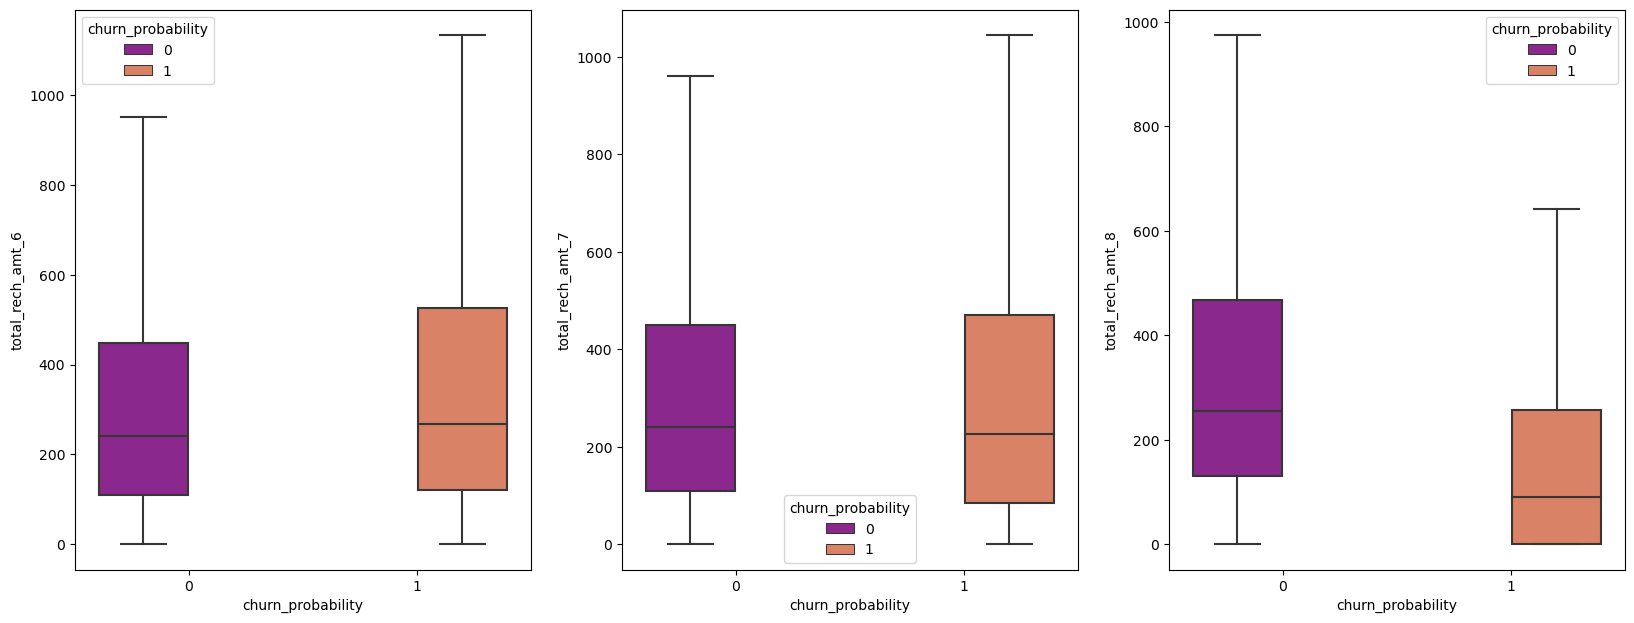

In [41]:
# Plot for total recharge amount
# create box plot for  6th, 7th and 8th month
plot_box_chart('total_rech_amt')

# Observations:

# We can see a drop in the total recharge amount for churned customers in the 8th Month.

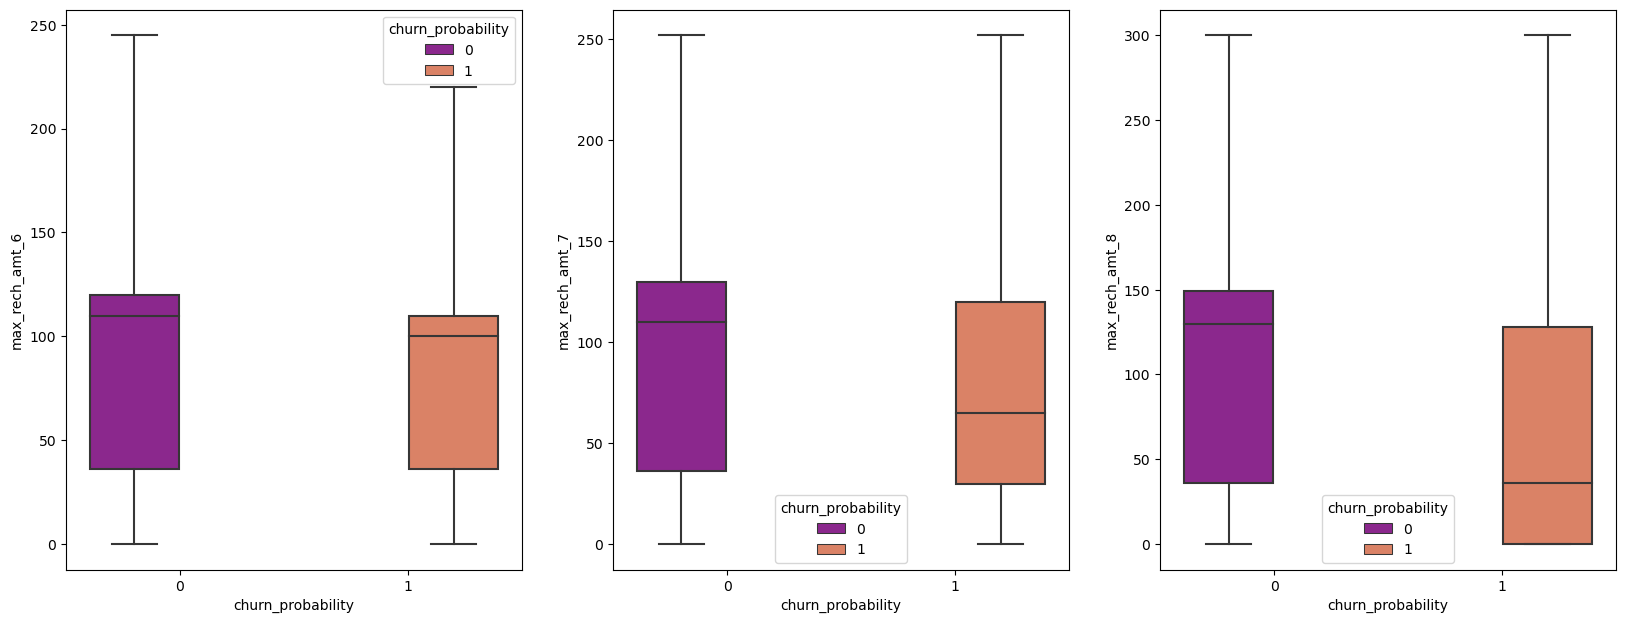

In [42]:
# Ploting for maximum recharge amount for data:
plot_box_chart('max_rech_amt')

# Observations:

# We can see that there is a huge drop in maximum recharge amount for data in the 8th month for churned customers.

In [43]:
# Let's check other recharge related variables:
other_recharge = tele_df_filtered.columns[tele_df_filtered.columns.str.contains('rech_num|max_rech_data',regex=True)]

In [44]:
# lets check the % of NA values for other recharge related variables
100*tele_df_filtered.loc[:,other_recharge].isnull().sum()/len(tele_df_filtered)



total_rech_num_6    0.0
total_rech_num_7    0.0
total_rech_num_8    0.0
dtype: float64

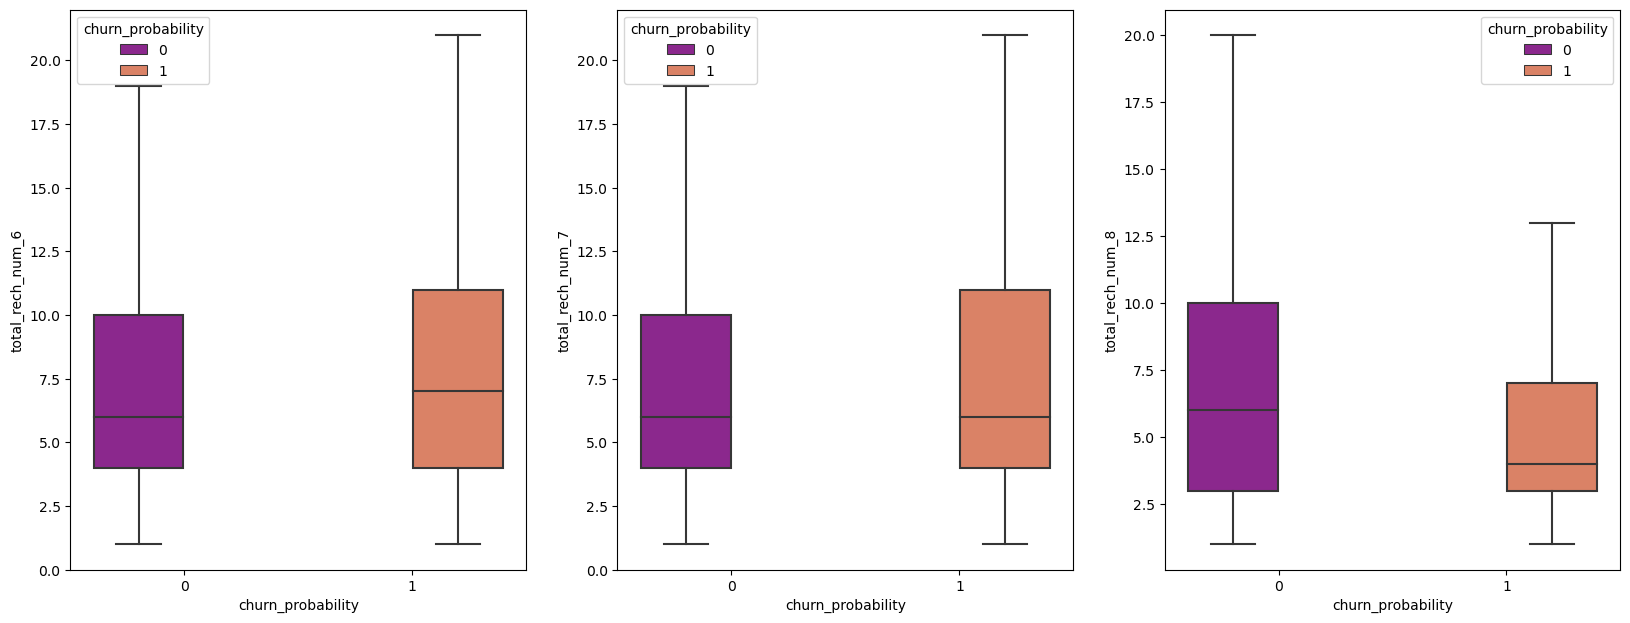

In [45]:
# Ploting for Total recharge for Number:
plot_box_chart('total_rech_num')

# Observations
# We can see that there is a huge drop in total recharge number also in the 8th month for churned customers.

In [46]:
#Getting the last day recharge amount columns
last_day_rech_amt = tele_df_filtered.columns[tele_df_filtered.columns.str.contains('day')]

In [47]:
last_day_rech_amt.tolist()

['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']

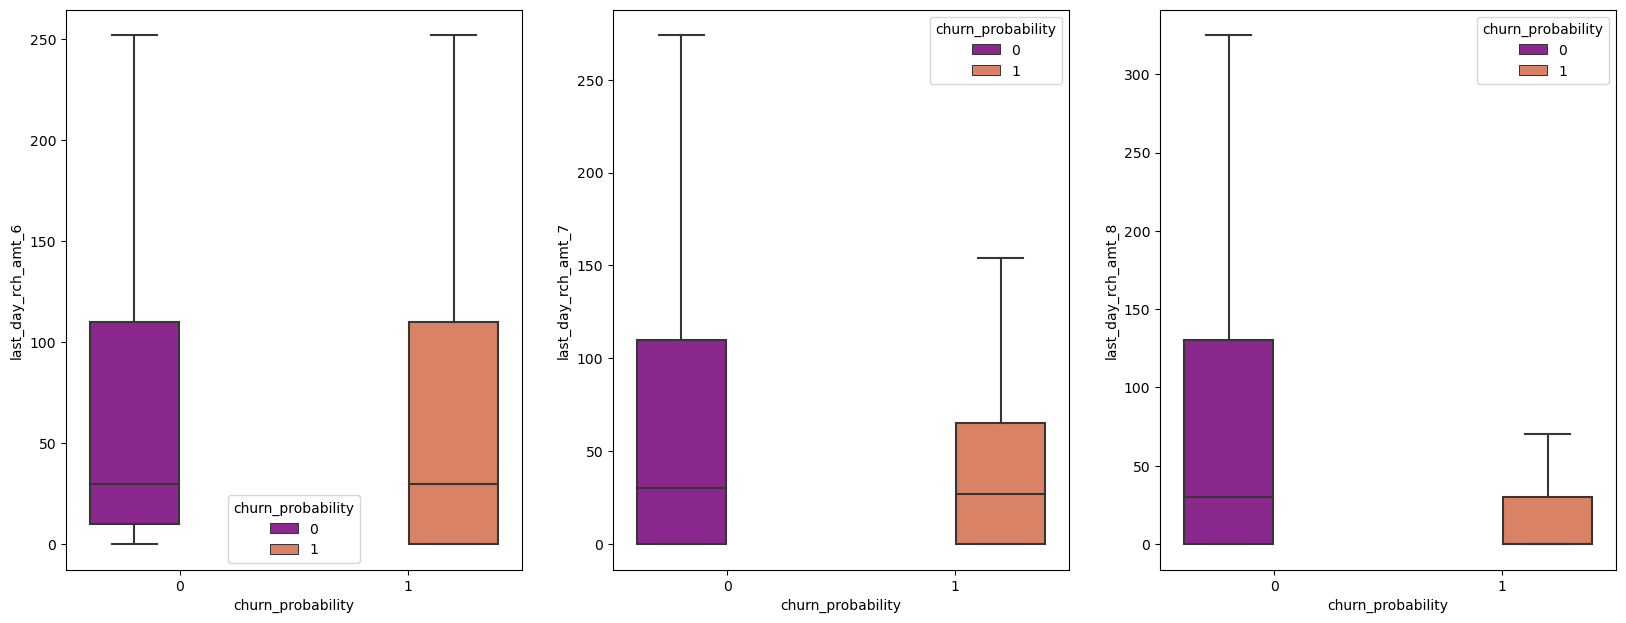

In [48]:
# Ploting for last day recharge amount:
plot_box_chart('last_day_rch_amt')

# Observations:
# We are getting a huge drop in 8th month recharge amount for churned customers.

#### 2G and 3G usage related attributes

In [49]:
usage_2g_and_3g = tele_df_filtered.columns[tele_df_filtered.columns.str.contains('2g|3g',regex=True)]
usage_2g_and_3g

Index(['vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6',
       'vol_3g_mb_7', 'vol_3g_mb_8', 'monthly_2g_6', 'monthly_2g_7',
       'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8',
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'],
      dtype='object')

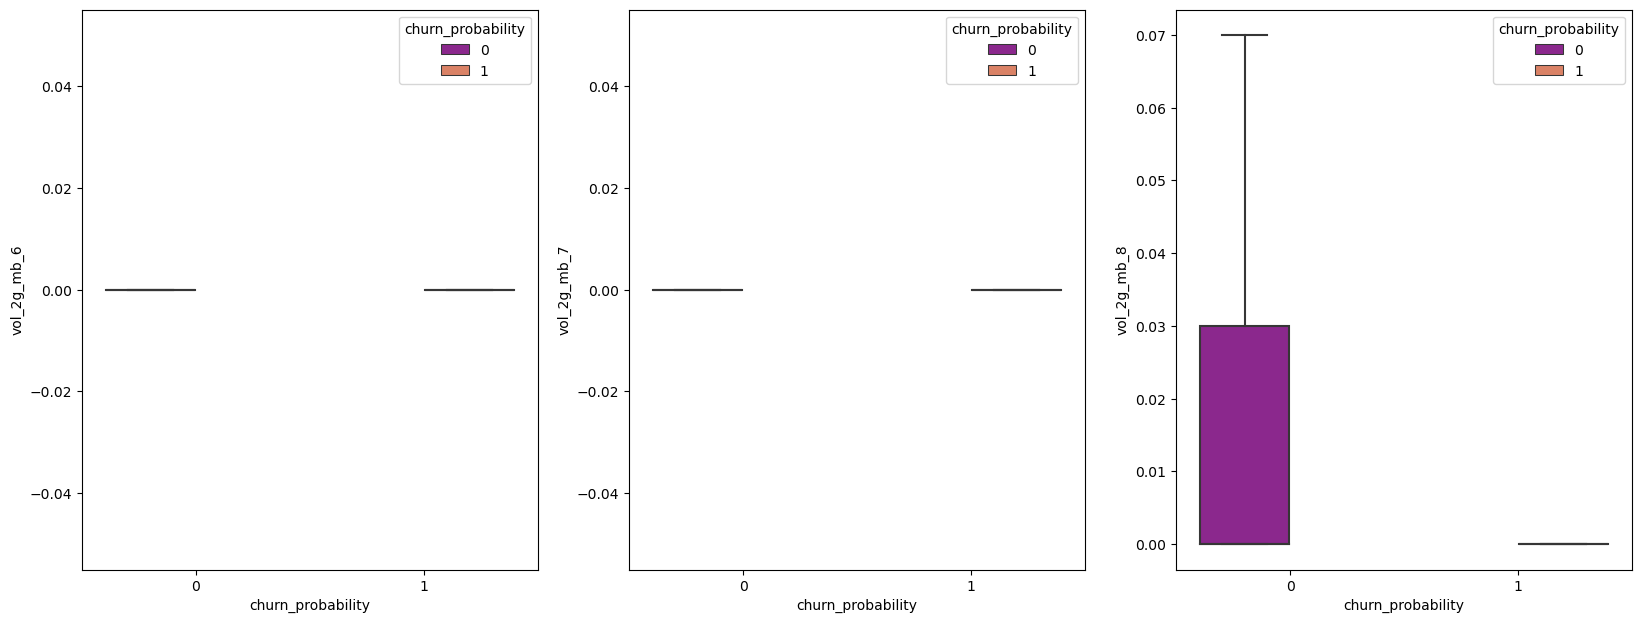

In [50]:
# Plot for volume of 2G and 3G usage columns:
plot_box_chart('vol_2g_mb')

# Observations:
# There is no significant data avaiable on data usage for analysis. 

#### Average Revenue Per User

In [51]:
# Check for columns for average revenue per user
arpu_cols = tele_df_filtered.columns[tele_df_filtered.columns.str.contains('arpu_')]
arpu_cols.tolist()

['arpu_6', 'arpu_7', 'arpu_8']

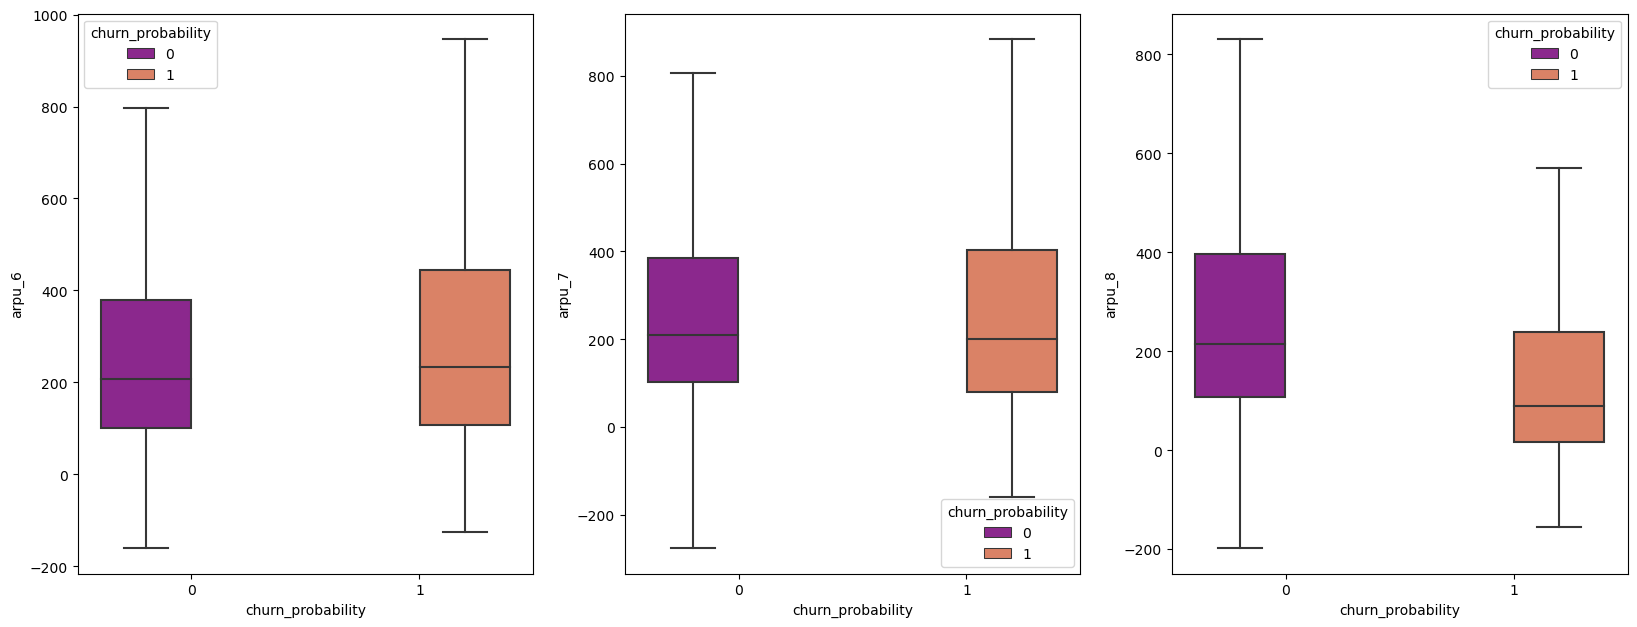

In [52]:
# Plotting arpu
plot_box_chart('arpu')

In [53]:
def plot_mean_bar_chart(df,columns_list):
    df_0 = df[df.churn_probability==0].filter(columns_list)
    df_1 = df[df.churn_probability==1].filter(columns_list)
    
    mean_df_0 = pd.DataFrame([df_0.mean()])
    mean_df_0.index = ['Non Churn']
    mean_df_1 = pd.DataFrame([df_1.mean()])
    mean_df_1.index = ['Churn']
    
    frames = [mean_df_0, mean_df_1]
    mean_bar = pd.concat(frames)
    
    mean_bar.T.plot.bar(figsize=(10,5),rot=0)
    plt.show()
    
    return mean_bar

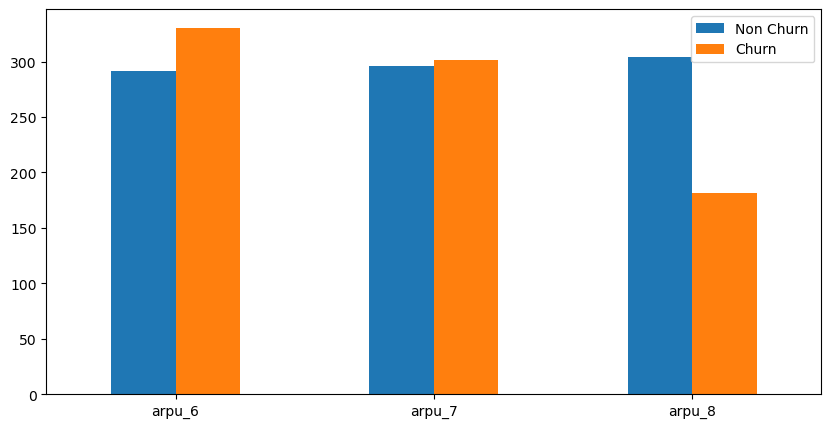

,arpu_6,arpu_7,arpu_8
Non Churn,291.285301,295.753069,304.305120
Churn,330.649022,301.875164,181.615719


In [54]:
plot_mean_bar_chart(tele_df_filtered, arpu_cols)

# Observations:
# We can see that huge drops for Arpu in 8th month for churned customers

#### Minute of Usage - Voice calls attributes analysis

In [55]:
mou_cols = tele_df_filtered.columns[tele_df_filtered.columns.str.contains('mou')]
mou_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mo

In [56]:
mou_og_cols6 = tele_df_filtered.columns[tele_df_filtered.columns.str.contains('.*_og_.*mou_6',regex=True)]
mou_og_cols6

Index(['roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6',
       'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6',
       'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6',
       'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'total_og_mou_6'],
      dtype='object')

In [57]:
def heatmap(x,y,dataframe):
    plt.figure(figsize=(x,y))
    sns.heatmap(dataframe.corr(),cmap="OrRd",annot=True)
    plt.show()

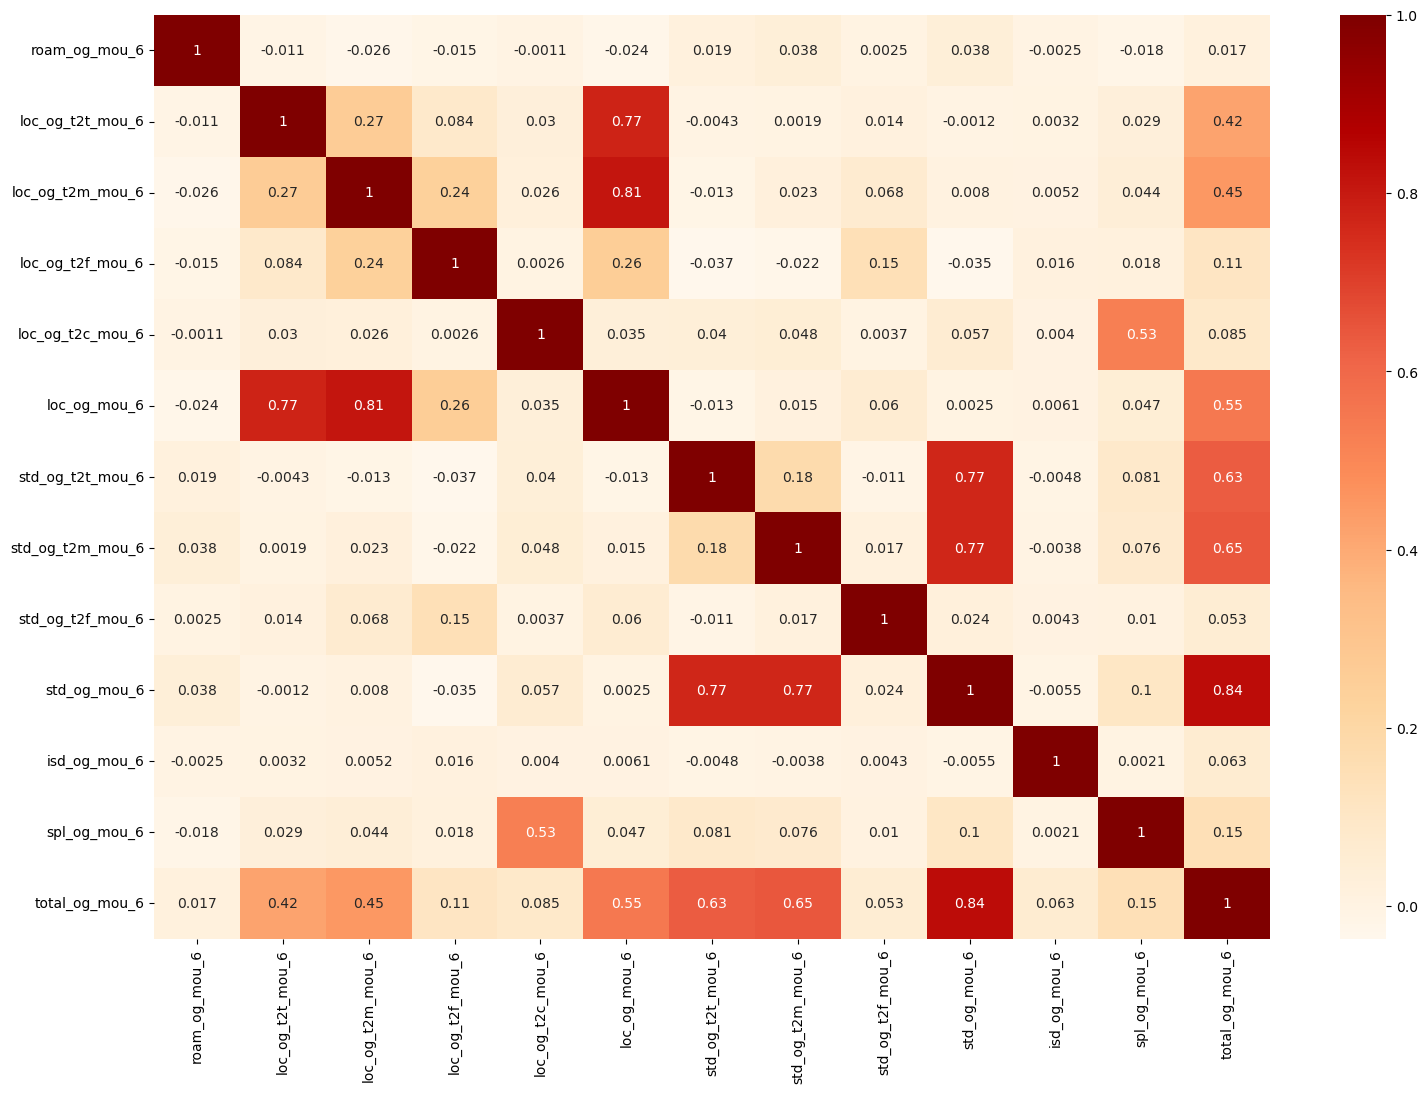

In [58]:
heatmap(18,12,tele_df_filtered.filter(mou_og_cols6))

# Observations:

# We can see that total_og_mou_6, std_og_mou_6, loc_og_t2m_mou_6 and loc_og_mou_6 seems to have strong correlation 
# with other fileds and they needs to be inspected to avoid any multicolinearity issues.

In [59]:
print(tele_df_filtered.loc[21,'total_og_mou_6'],"==",tele_df_filtered.loc[21,['loc_og_mou_6','roam_og_mou_6','isd_og_mou_6','spl_og_mou_6','std_og_mou_6']].sum())
print(tele_df_filtered.loc[21,'loc_og_mou_6'],"==",tele_df_filtered.loc[21,['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6']].sum())
print(tele_df_filtered.loc[21,'std_og_mou_6'],"==",tele_df_filtered.loc[21,['std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6']].sum())

# Observations:
# We can see that total_og_mou_6, std_og_mou_6 and loc_og_mou_6 is a combination of other variables present in dataset.
# So we can remove these columns for all months from the data set

213.53 == 213.52
191.74 == 191.74
21.78 == 21.77


In [60]:
# Drop correlated columns
list_total_og_cols = tele_df_filtered.columns[tele_df_filtered.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)]
tele_df_filtered.drop(list_total_og_cols,axis=1,inplace=True)
log("Columns dropped - ")
list_total_og_cols.tolist()

> <span style='color:blue'>Columns dropped - </span>

['loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8']

In [61]:
tele_df_filtered.shape

(61895, 123)

#### Check for incoming mou variables

In [62]:
mou_ic_cols6 = tele_df_filtered.columns[tele_df_filtered.columns.str.contains('.*_ic_.*mou_6',regex=True)]
mou_ic_cols6

Index(['roam_ic_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6',
       'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6',
       'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6',
       'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6'],
      dtype='object')

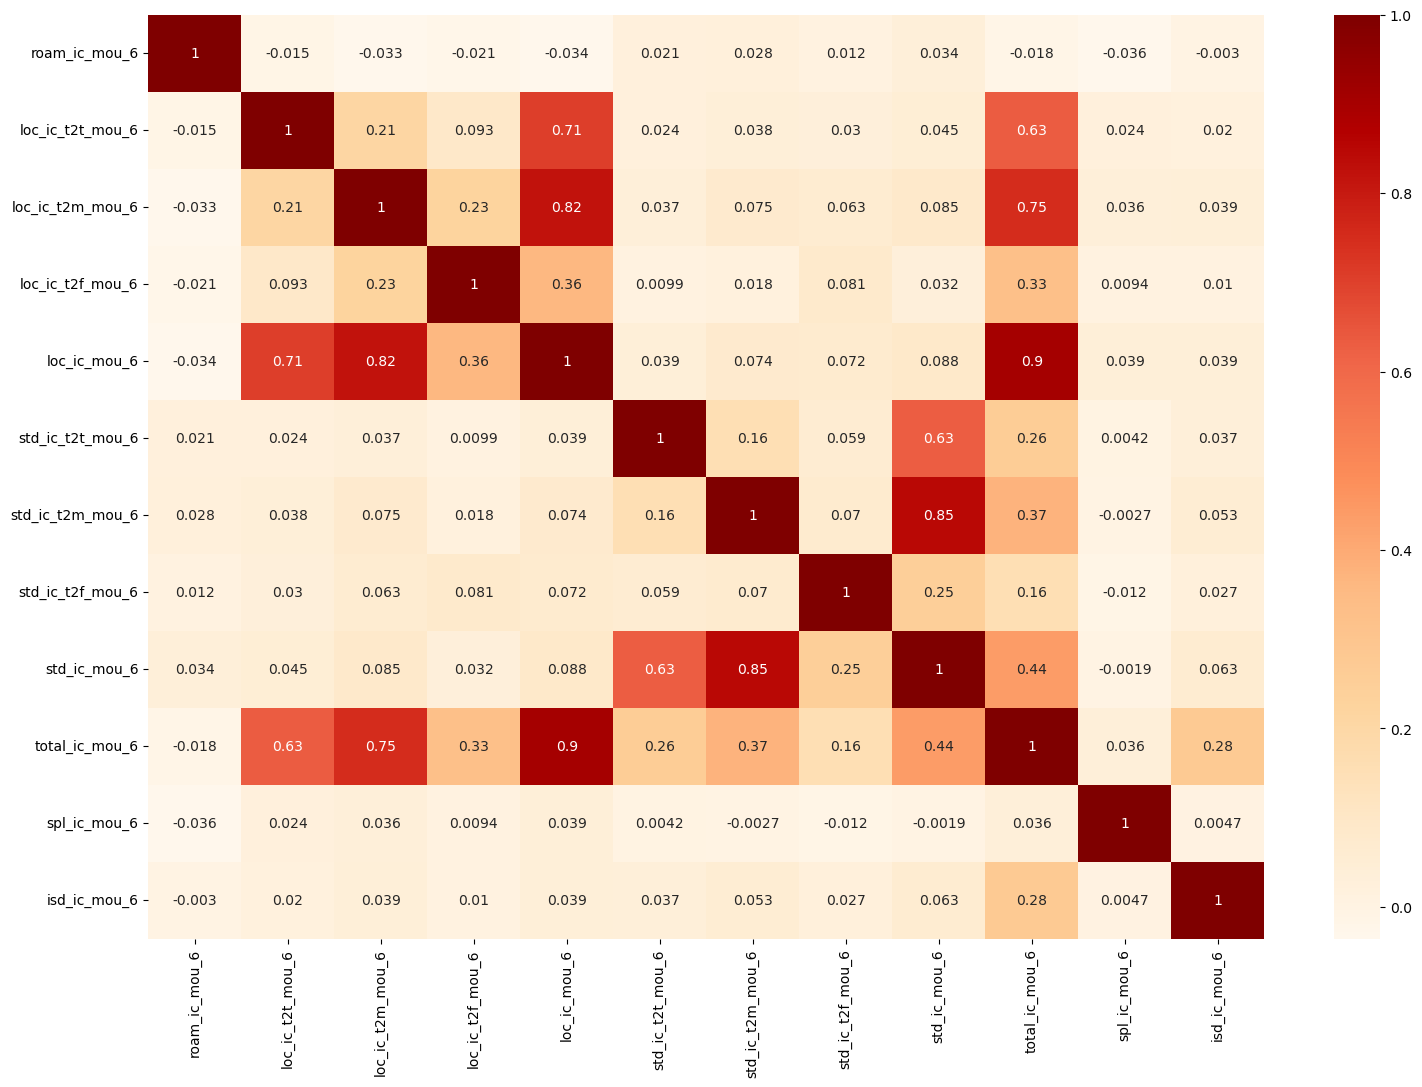

In [63]:
heatmap(18,12,tele_df_filtered.filter(mou_ic_cols6))

# Observations:

# We can see that total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 seems to have strong correlation with other fileds
# and they needs to be inspected to avoid any multicolinearity issues.

In [64]:
print(tele_df_filtered.loc[21,'total_ic_mou_6'],"==",tele_df_filtered.loc[21,['loc_ic_mou_6','roam_ic_mou_6','isd_ic_mou_6','spl_ic_mou_6','std_ic_mou_6']].sum())
print(tele_df_filtered.loc[21,'loc_ic_mou_6'],"==",tele_df_filtered.loc[21,['loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6']].sum())
print(tele_df_filtered.loc[21,'std_ic_mou_6'],"==",tele_df_filtered.loc[21,['std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6']].sum())

# Observations:
# We can see that total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 is a combination of other variables present in dataset.
# So we can remove these columns for all months from the data set

338.54 == 338.53
265.39 == 265.38
73.14 == 73.14


In [65]:
list_total_ic_cols = tele_df_filtered.columns[tele_df_filtered.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)]
tele_df_filtered.drop(list_total_ic_cols,axis=1,inplace=True)
log("Columns dropped - ")
list_total_ic_cols.tolist()

> <span style='color:blue'>Columns dropped - </span>

['loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_ic_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8']

In [66]:
tele_df_filtered.shape

(61895, 114)

#### Offnet Usage

In [67]:
offnet_usage_service_col = tele_df_filtered.columns[tele_df_filtered.columns.str.contains('offnet.*mou',regex=True)]

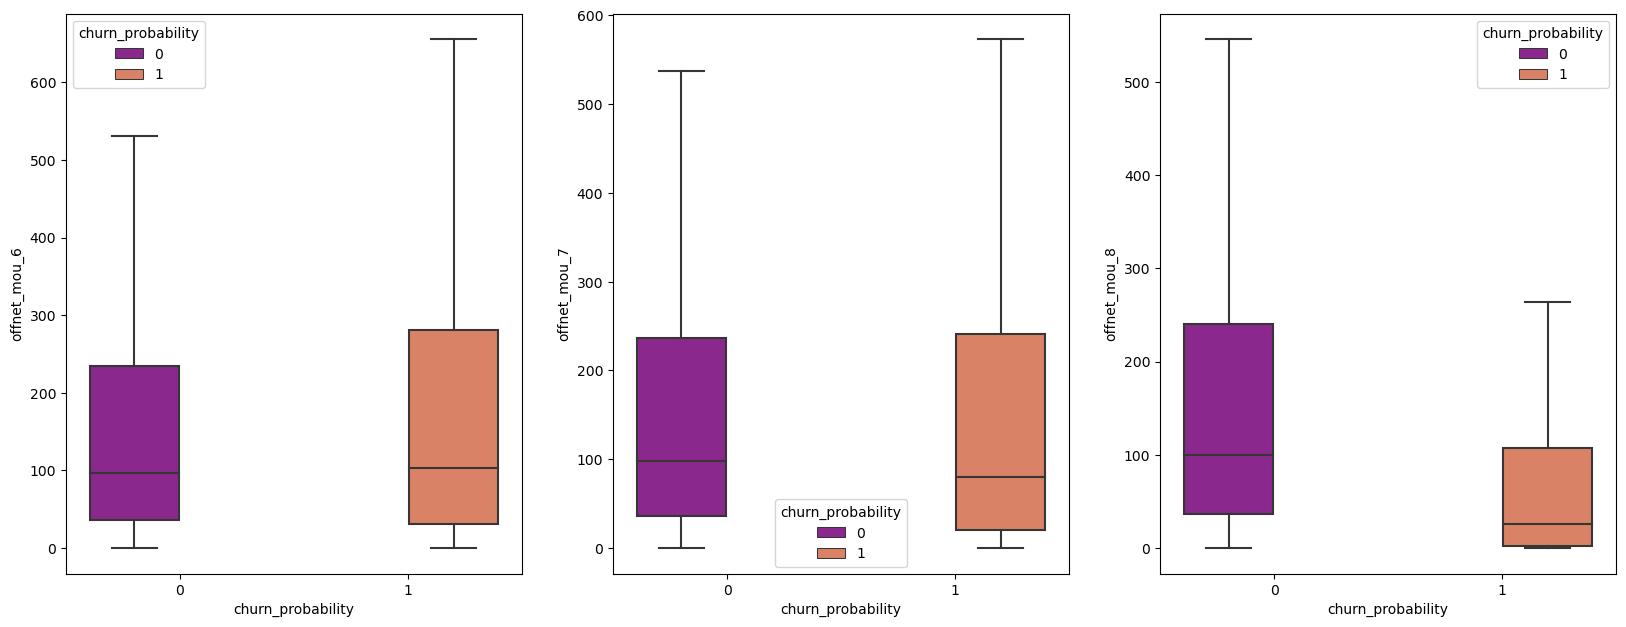

In [68]:
# Offnet mou values for churned and non churned customers
plot_box_chart('offnet_mou')

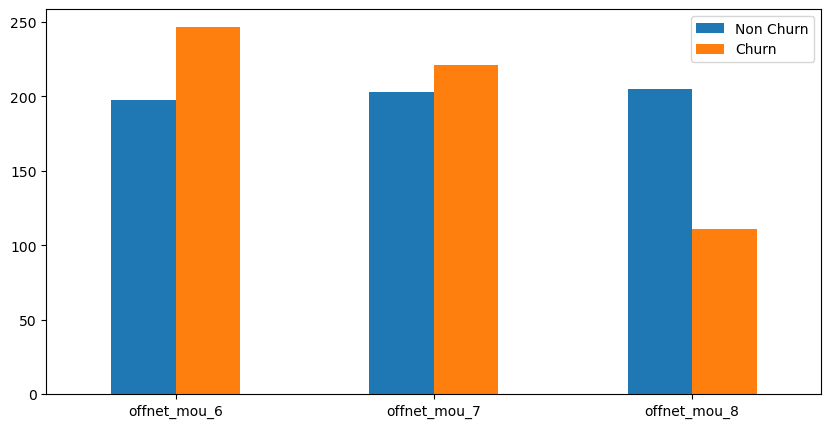

,offnet_mou_6,offnet_mou_7,offnet_mou_8
Non Churn,197.665836,202.994294,204.779635
Churn,246.297194,220.753998,110.656865


In [69]:
plot_mean_bar_chart(tele_df_filtered, offnet_usage_service_col)

#Observations:

# We can see the drop for offnet mou services in the 8th month

#### On-Net Usage

In [70]:
#minutes of usage related columns
onnet_usage_service =  tele_df_filtered.columns[tele_df_filtered.columns.str.contains('^onnet.*mou',regex=True)]
onnet_usage_service

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8'], dtype='object')

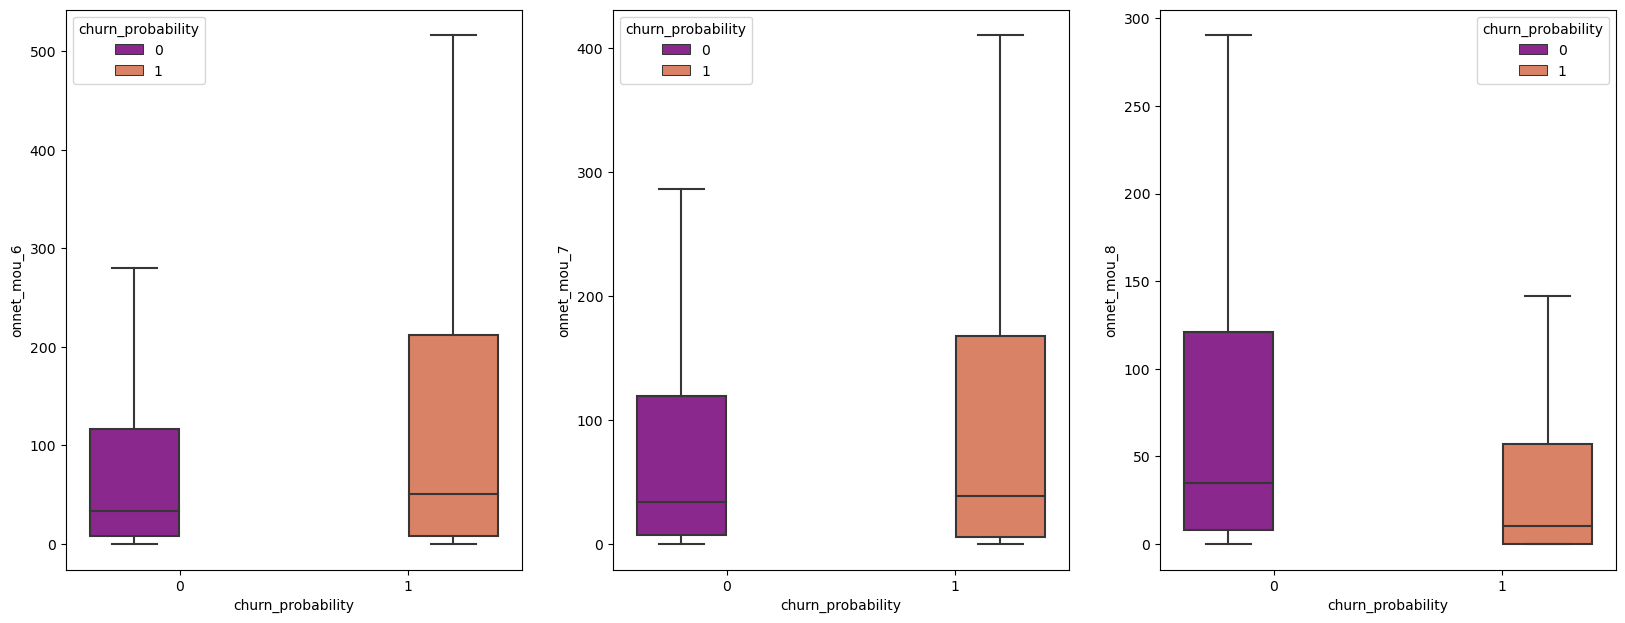

In [71]:
# Plot the onnet
plot_box_chart('onnet_mou')

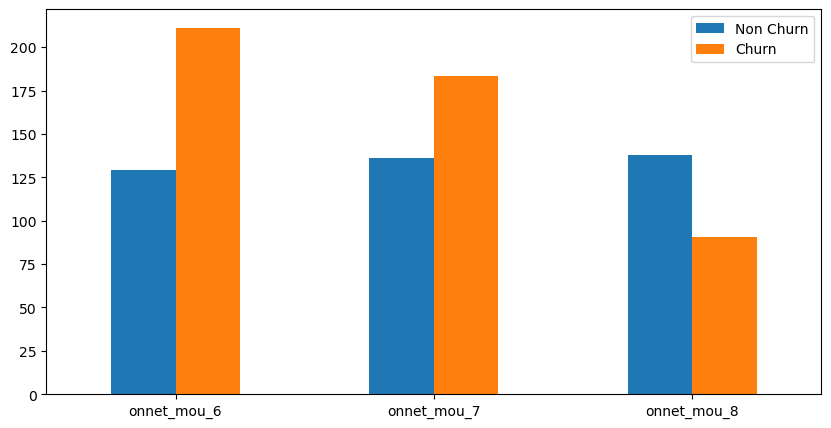

,onnet_mou_6,onnet_mou_7,onnet_mou_8
Non Churn,129.272300,135.886862,137.760850
Churn,211.255324,183.387529,90.477283


In [72]:
plot_mean_bar_chart(tele_df_filtered, onnet_usage_service)

# Obervations:
# We also see that there is a drop in Onnet usage in the 8th month for churned customers

#### Tenure Analysis For Customers

In [73]:
tenure_data = tele_df_filtered.copy()

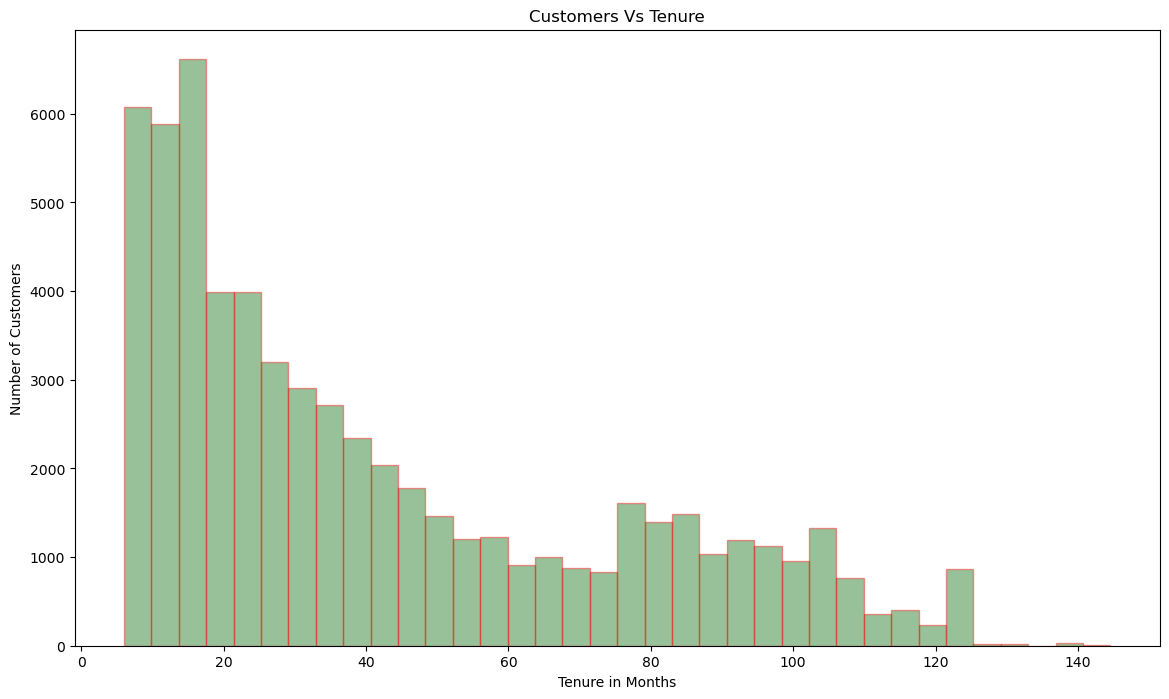

In [74]:
plt.figure(figsize=(14,8))
# aon --> Age on network - number of days the customer is using the operator T network
tenure_data['tenure'] = tenure_data['aon']/30
tenure_data['tenure'].head()
ax = sns.distplot(tenure_data['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Tenure in Months')
ax.set_title('Customers Vs Tenure')
plt.show()

In [75]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tn_range, labels=tn_label)
tenure_data['tenure_range'].head()

0        NaN
1    1-2 Yrs
2    2-5 Yrs
3    2-5 Yrs
4    1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

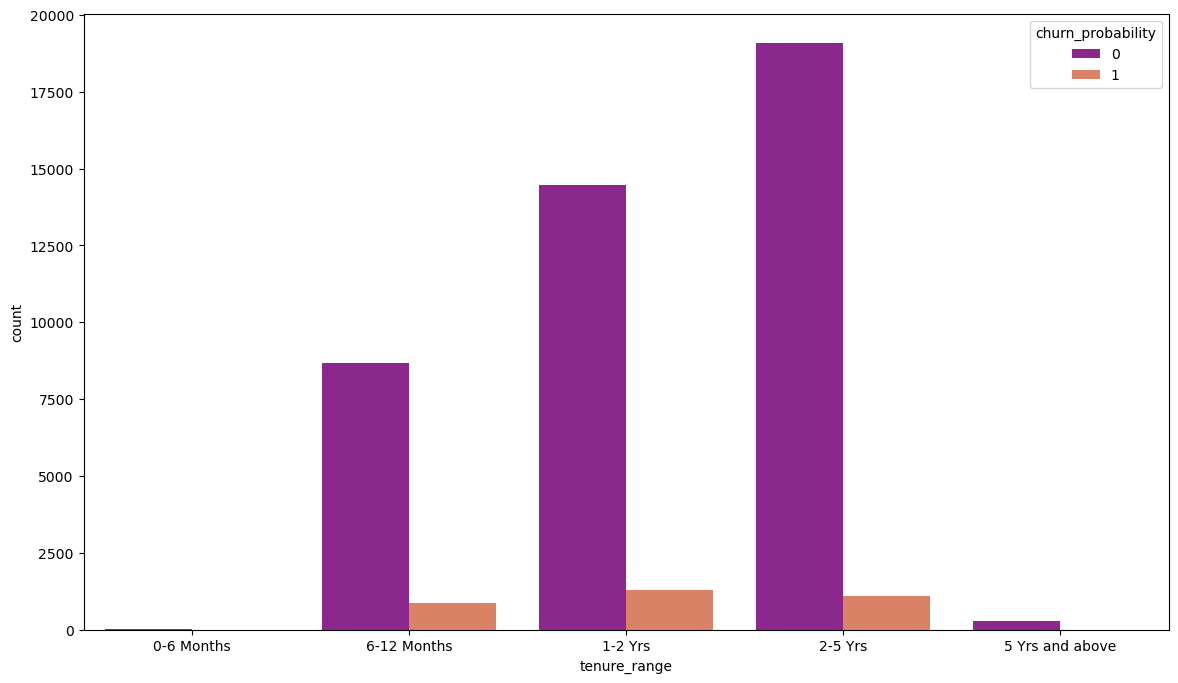

In [76]:
plt.figure(figsize=(14,8))
sns.countplot(x = 'tenure_range', hue = 'churn_probability',data = tenure_data,palette=("plasma"))
plt.show()

In [77]:
# We have number of days the customer is on the network. so Last date of month columns will not add 
# any more value, so let's drop them

# 4. Modelling

### Create X, y and then Train test split

In [78]:
y = tele_df_filtered["churn_probability"]
X = tele_df_filtered.drop(["churn_probability", "id"], axis=1)

X.shape, y.shape

((61895, 112), (61895,))

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((49516, 112), (12379, 112), (49516,), (12379,))

In [80]:
#Utility methods

def get_scree_plot(X):
    pca = PCA(svd_solver='randomized', random_state=101)
    pca.fit(X)
    fig = plt.figure(figsize = (8,6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()
    return pca

In [81]:
#Scaling train data

log("Scaling the data ....")

scaler = StandardScaler()
X_col = X_train.columns
X_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_scaled, columns=X_col)
X_test_scale_ar = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scale_ar, columns=X_col)

#X_train_scaled = scale_data(X_train)
X_train_scaled.head()
X_test_scaled.head()

> <span style='color:blue'>Scaling the data ....</span>

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,-0.875415,-0.593710,-0.513074,-0.449002,-0.427136,-0.362880,-0.632457,-0.376746,-0.267502,-0.161865,...,-0.208588,-0.203869,-0.215591,-0.131026,-0.133735,-0.127812,-0.947479,-0.262135,-0.251736,-0.236079
1,-0.035681,-0.033536,0.068366,-0.191519,-0.235246,-0.282958,-0.225388,-0.130597,-0.164549,-0.172439,...,-0.208588,-0.203869,2.389393,-0.131026,1.398432,-0.127812,-0.658211,1.034178,0.277054,0.326287
2,0.569400,1.397039,0.403133,-0.341133,-0.286983,-0.293827,0.043451,-0.109621,-0.104212,-0.172439,...,-0.208588,-0.203869,2.389393,-0.131026,1.398432,-0.127812,-0.738332,-0.262135,0.265126,0.101069
3,-0.250744,-0.427921,-0.467718,-0.200725,0.011260,0.014193,-0.590767,-0.554218,-0.477026,-0.172439,...,-0.208588,-0.203869,-0.215591,-0.131026,-0.133735,-0.127812,0.576902,-0.262135,-0.251736,-0.236079
4,0.412519,1.048757,0.184418,0.408184,0.355102,0.066014,0.417749,0.086289,0.618809,0.014558,...,-0.208588,-0.203869,-0.215591,-0.131026,-0.133735,-0.127812,-0.152512,-0.262135,-0.222239,-0.236079


<Axes: >

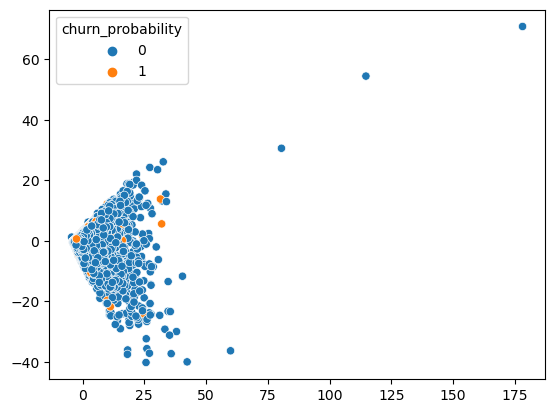

In [82]:
pca = PCA(random_state=42)
pca_components = pca.fit_transform(X_train_scaled)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

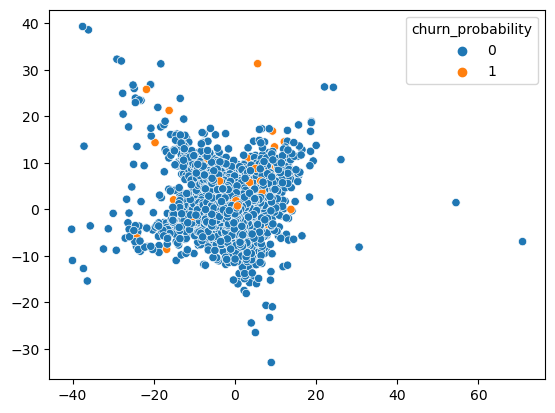

In [83]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

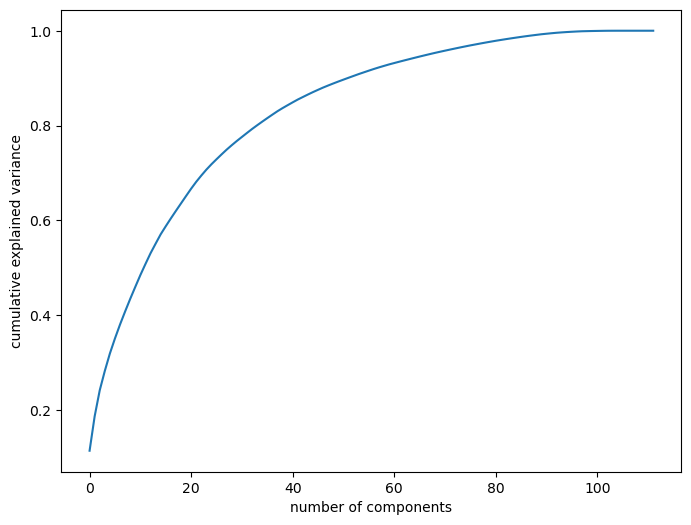

,PC1,PC2,PC3,Feature
0,0.229496,0.085787,0.021725,arpu_6
1,0.235600,0.088864,0.029027,arpu_7
2,0.228272,0.082891,0.021346,arpu_8
3,0.101710,0.133440,0.120606,onnet_mou_6
4,0.107073,0.143038,0.136051,onnet_mou_7
5,0.102978,0.134875,0.128456,onnet_mou_8
6,0.152293,0.144067,0.025599,offnet_mou_6
7,0.157012,0.155368,0.039748,offnet_mou_7
8,0.148876,0.143135,0.033609,offnet_mou_8
9,0.032387,0.024764,0.005910,roam_ic_mou_6


In [84]:
pca = get_scree_plot(X_train_scaled)

col = list(X_train_scaled.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head(10)

#Observations:

# It seems variance is reducing after 70 features.
# We can see the important feature list below.
# 

In [135]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

# Observations:
# Looks like 72 components are enough to describe 95% of the variance in the dataset.We'll choose 60 components for our 
# modeling

array([ 11.51,  18.76,  24.25,  28.27,  31.92,  34.86,  37.68,  40.38,
        42.94,  45.44,  47.85,  50.12,  52.33,  54.33,  56.31,  58.07,
        59.77,  61.41,  63.03,  64.61,  66.16,  67.64,  69.09,  70.42,
        71.57,  72.66,  73.71,  74.73,  75.67,  76.58,  77.46,  78.31,
        79.15,  79.94,  80.72,  81.49,  82.23,  82.96,  83.63,  84.27,
        84.87,  85.45,  85.99,  86.51,  86.99,  87.46,  87.92,  88.36,
        88.8 ,  89.22,  89.64,  90.04,  90.43,  90.81,  91.18,  91.53,
        91.87,  92.2 ,  92.51,  92.8 ,  93.09,  93.37,  93.65,  93.92,
        94.19,  94.46,  94.72,  94.98,  95.23,  95.47,  95.71,  95.94,
        96.17,  96.39,  96.61,  96.83,  97.04,  97.24,  97.44,  97.63,
        97.82,  98.  ,  98.17,  98.34,  98.5 ,  98.66,  98.81,  98.96,
        99.1 ,  99.23,  99.34,  99.45,  99.55,  99.64,  99.72,  99.79,
        99.85,  99.9 ,  99.94,  99.97, 100.  , 100.02, 100.04, 100.05,
       100.05, 100.05, 100.05, 100.05, 100.05, 100.05, 100.05, 100.05])

#### Re-sampling

In [144]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA

In [146]:
pca2 = IncrementalPCA(n_components=72) 

X_scaled_filtered = pca2.fit_transform(X_train_scaled)
X_train_pca = pd.DataFrame(data=X_scaled_filtered)

X_train_pca.shape

(49516, 72)

In [75]:
X_test_sc_filtered = pca2.transform(X_test_scaled)
X_test_pca = pd.DataFrame(data=X_test_sc_filtered)

In [76]:
X_test_pca.shape

(12379, 72)

## 4.1 Logistic Regression Modelling

In [189]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

lr = LogisticRegression()
model = lr.fit(X_train,y_train)
#Making prediction on the test data
pred_probs_test = model.predict_proba(X_test)[:,1]
log("Linear Regression Accurancy : "+"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test)))

> <span style='color:blue'>Linear Regression Accurancy : 0.84</span>

## 4.2 Tree Model - without PCA

In [168]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import itertools
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, RocCurveDisplay
from sklearn.metrics import recall_score,precision_score,roc_auc_score,f1_score,accuracy_score,confusion_matrix

consolidate_summary = pd.DataFrame()

In [169]:
# Utility methods:

def plot_confusion_matrix(cm):
    
    #This function prints and plots the confusion matrix.
    
    classes=[0,1]
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def print_model_metrics(y_test,y_pred,model_name):
    header(model_name+" Model Stats Scores Summary : ")
    cp = confusion_matrix(y_test,y_pred)
    plt.figure()
    plot_confusion_matrix(cp)
    plt.show()
    
    accuracy = round(accuracy_score(y_test,y_pred),2)
    recall = round(recall_score(y_test,y_pred),2)
    precision = round(precision_score(y_test,y_pred),2)
    auc = round(roc_auc_score(y_test,y_pred),2)
    f1 = round(f1_score(y_test,y_pred),2)
    
    data = [[model_name,accuracy,recall,precision,auc,f1]] 
    df = pd.DataFrame(data, columns = ['Model', 'Accuracy','Precision','Recall','AUC','F1'])
    add_to_global_summary(df)
    return df 

def add_to_global_summary(df) :
    global consolidate_summary 
    consolidate_summary = consolidate_summary.append(df,ignore_index=True)

In [170]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [171]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

RandomForestClassifier(max_features='auto', n_estimators=10)

In [172]:
predictions = rfc.predict(X_test)

------ 

### RandomForest (Default) Model Stats Scores Summary : 

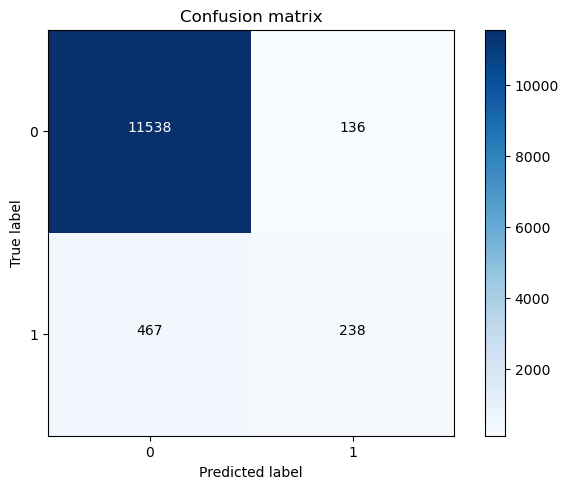

,Model,Accuracy,Precision,Recall,AUC,F1
0,RandomForest (Default),0.95,0.34,0.64,0.66,0.44


In [173]:
print_model_metrics(y_test,predictions,"RandomForest (Default)")

## 4.3 Tree Model - With PCA

In [85]:
rfc_pca = RandomForestClassifier()
rfc_pca.fit(X_train_pca,y_train)

RandomForestClassifier()

In [86]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

RandomForestClassifier(max_features='auto', n_estimators=10)

In [87]:
predictions = rfc_pca.predict(X_test_pca)

------ 

### RandomForest (Default-With PCA) Model Stats Scores Summary : 

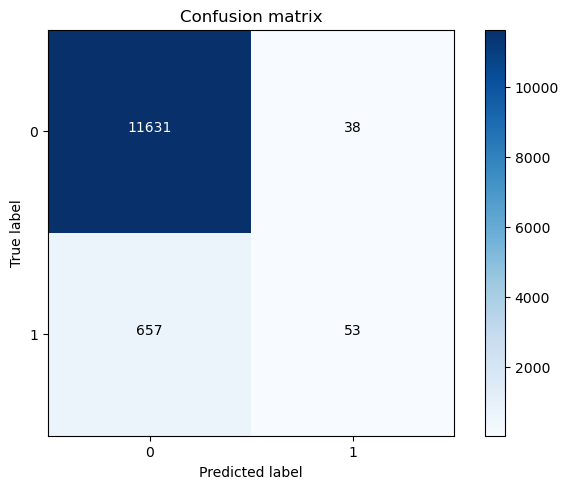

,Model,Accuracy,Precision,Recall,AUC,F1
0,RandomForest (Default-With PCA),0.94,0.07,0.58,0.54,0.13


In [88]:
print_model_metrics(y_test,predictions,"RandomForest (Default-With PCA)")

## 4.4 Tree Model - Hyper Parameter Tuning

# HARDWARE RESOURCES NOT ENOUGH TO PROCESS IT

In [423]:
def tune_hyperparameter(parameters,x_train,y_train,n_folds = 5,max_depth=0):
    
    if(max_depth==0):
        rf = RandomForestClassifier()
    else :
        rf = RandomForestClassifier(max_depth=max_depth)
        
    rf = GridSearchCV(rf, parameters, cv=n_folds,n_jobs = -1, scoring="accuracy",return_train_score=True)
    rf.fit(x_train, y_train)
    scores = rf.cv_results_

    for key in parameters.keys():
        hyperparameters = key
        break

    # plotting accuracies for parameters
    plt.figure(figsize=(16,5))
    plt.plot(scores["param_"+hyperparameters], scores["mean_train_score"], label="training accuracy")
    plt.plot(scores["param_"+hyperparameters], scores["mean_test_score"], label="test accuracy")
    plt.xlabel(hyperparameters)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

##### Tuning Max Depth - It is going under huge process beyond hardware capacity.

In [ ]:
# parameters to build the model on
#parameters = {'max_depth': range(2, 40, 5)}
#tune_hyperparameter(parameters,X_train_pca,y_train)

In [ ]:
# Observations:
# There is no significant different in performance. We can keep it between 15 to 20. We will 
# keep max depth comparatively low to avoid overfitting.

##### Let's tune with n_estimators

In [ ]:
# parameters to build the model on
#parameters = {'n_estimators': range(100, 2000, 200)}
#tune_hyperparameter(parameters,X_train_pca,y_train)

## 4.5 XGBoost Model

In [90]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [91]:
# fit model on training data with default hyperparameters
model_xg = XGBClassifier()
model_xg.fit(X_train_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [92]:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=None,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=1, nthread=None, num_parallel_tree=None, ...)

In [94]:
# evaluate predictions
y_pred = model_xg.predict(X_test_pca)

------ 

### XGBoost (Default - With PCA) Model Stats Scores Summary : 

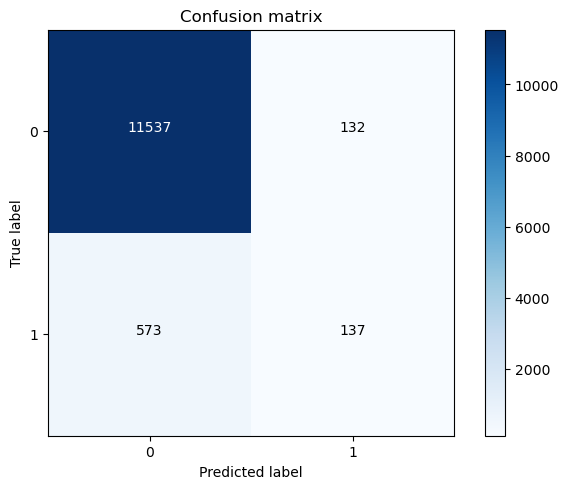

,Model,Accuracy,Precision,Recall,AUC,F1
0,XGBoost (Default - With PCA),0.94,0.19,0.51,0.59,0.28


In [96]:
print_model_metrics(y_test, y_pred ,'XGBoost (Default - With PCA)')

In [ ]:
# Observations: 
# Accuracy wit default hyper parameters is 94%

## 4.5 XGBoost Model - Hyperparameter tuning

In [97]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 5

# specify range of hyperparameters
param_grid = {'learning_rate': [0.1,0.2,0.3], 
             'subsample': [0.3,0.4,0.5]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'accuracy', # accuracy
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True) 

In [98]:
# fit the model
model_cv.fit(X_train_pca, y_train) 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'subsample': [0.3, 0.4, 0.5]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [100]:
GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=2, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'subsample': [0.3, 0.4, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     device=None, early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=N...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None, max_delta_step=0,
                                     max_depth=2, max_leaves=None,
                                     min_child_weight=1, missing=None,
                                     monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=1, nthread=None,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'subsample': [0.3, 0.4, 0.5]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [101]:
# cv results
cv_results_xboost = pd.DataFrame(model_cv.cv_results_)
cv_results_xboost['param_learning_rate'] = cv_results_xboost['param_learning_rate'].astype('float')

In [102]:
# printing the optimal accuracy score and hyperparameters
log('We can get accuracy of **'+str(round(model_cv.best_score_,2))+'** using '+str(model_cv.best_params_))

> <span style='color:blue'>We can get accuracy of **0.94** using {'learning_rate': 0.1, 'subsample': 0.5}</span>

In [106]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': 0.1,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.5,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params,max_depth=2, n_estimators=200)
model.fit(X_train_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None,
              params={'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.5}, ...)

In [107]:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params={'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.5},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=2,
              max_leaves=None, min_child_weight=1, missing=None,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=1, nthread=None, num_parallel_tree=None, ...)

In [109]:
# predict
y_pred = model.predict(X_test_pca)

------ 

### XGBoost (Hyper Tuned) Model Stats Scores Summary : 

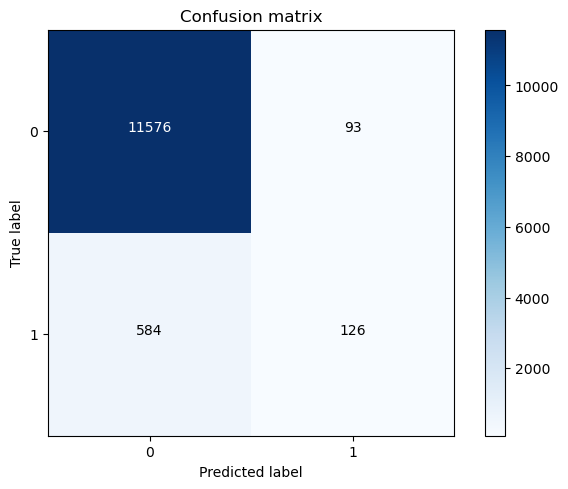

,Model,Accuracy,Precision,Recall,AUC,F1
0,XGBoost (Hyper Tuned),0.95,0.18,0.58,0.58,0.27


In [110]:
print_model_metrics(y_test, y_pred,'XGBoost (Hyper Tuned)')

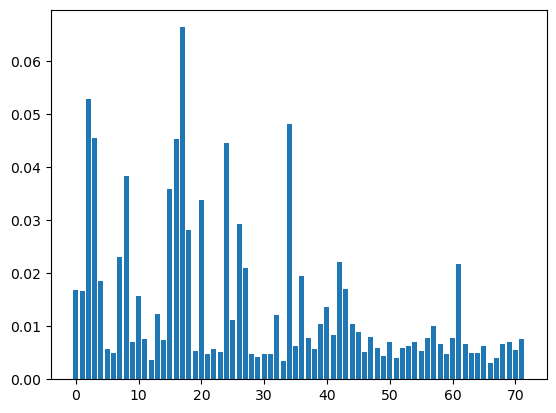

In [111]:
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [121]:
X_train_pca.shape

(49516, 72)

------ 

### Tenure vs. Churn Count

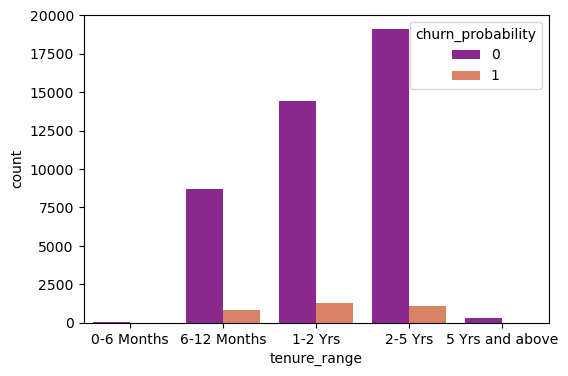

In [195]:
header("Tenure vs. Churn Count")
plt.figure(figsize=(6,4))
sns.countplot(x = 'tenure_range', hue = 'churn_probability',data = tenure_data,palette=("plasma"))
plt.show()

### Recommendations
#### Business Insights

###### Less number of **high value customer** are churing but for last **6 month** no new high valued cusotmer is onboarded which is concerning and company should concentrate on that aspect.

###### Customers with less than 4 years of tenure are more likely to churn and company should concentrate more on that segment by rolling out new schems to that group.

###### Average revenue per user (arpu) seems to be most important feature in determining churn prediction.

###### Local Outgoing calls made to landline , fixedline , mobile and call center provides a strong indicator of churn behaviour.



#### Model Insights

In [153]:
consolidate_summary.head(10)

,Model,Accuracy,Precision,Recall,AUC,F1
0,RandomForest (Default),0.95,0.31,0.69,0.65,0.43
1,RandomForest (Default-With PCA),0.94,0.07,0.58,0.54,0.13
3,XGBoost (Default - With PCA),0.94,0.19,0.51,0.59,0.28
4,XGBoost (Hyper Tuned),0.95,0.18,0.58,0.58,0.27


### 5. Creating Submission File

In [150]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [154]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


In [180]:

submission_data = pd.DataFrame(unseen, columns = X_train_scaled.columns)
submission_data.fillna(0, inplace=True)


In [181]:
submission_scaled = scaler.transform(submission_data)
df_submission_scaled = pd.DataFrame(data = submission_scaled)

submission_pca = pca2.transform(df_submission_scaled)
df_submission_pca = pd.DataFrame(data = submission_pca)


#### Predict using XGBoost - hyper tuned model

In [182]:
unseen['churn_probability'] = model.predict(df_submission_pca)

In [183]:
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [185]:
output.to_csv('submission_pca_lr_13jul.csv',index=False)